# Education Supplies Application Screening

# 1. Introduction

#### Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

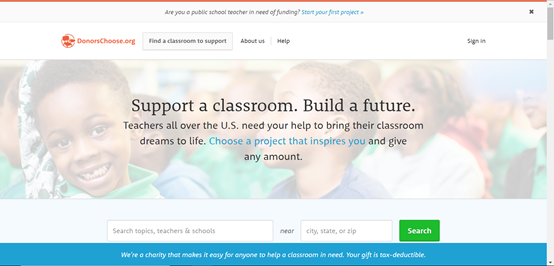

## Main problems

#### DonorsChoose.org receives hundreds of thousands of proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

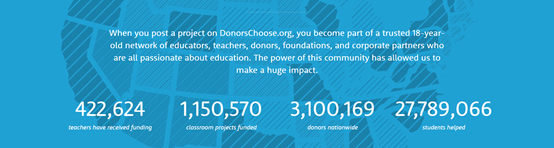

#### Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are two main problems they need to solve:

1.	How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
2.	How to increase the consistency of project vetting across different volunteers to improve the experience for teachers

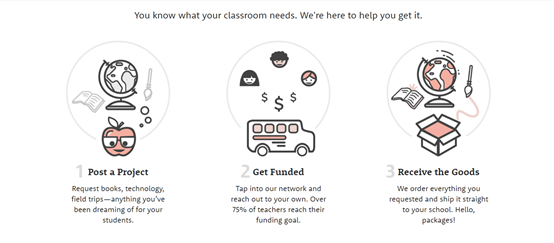

## Our goals

#### Build an algorithm to pre-screen applications, so that DonorsChoose.org can auto-approve some applications quickly, and volunteers can spend their time on more nuanced and detailed project vetting processes
#### If the model is reliable, it can help more teachers get funded more quickly, and with less cost to DonorsChoose.org, allowing them to channel even more funding directly to classrooms across the country.

## Datasets

#### The dataset contains information from teachers' project applications to DonorsChoose.org including teacher attributes, school attributes, and the project proposals including application essays. We need to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved.

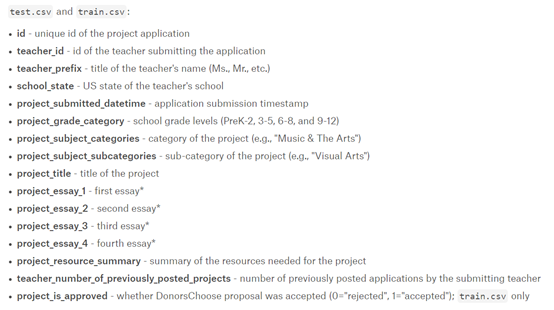

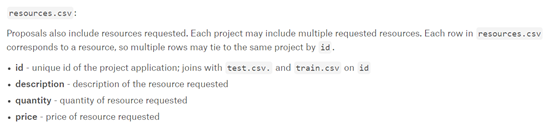

# 2.Feature Engineering

In [84]:
import time
start = time.time()

In [85]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.pipeline import FeatureUnion

In [87]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
import eli5

In [89]:
# models
from sklearn import feature_selection
import xgboost as xgb

In [90]:
import lightgbm as lgb

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
from scipy.sparse import hstack, csr_matrix
import scipy.stats as st

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [93]:
# Load
train = pd.read_csv("train.csv",index_col="id",low_memory=False,
                    parse_dates=["project_submitted_datetime"])#.sample(1000,random_state=23)
traindex = train.index
test = pd.read_csv("test.csv",index_col="id",low_memory=False,
                    parse_dates=["project_submitted_datetime"])#.sample(1000,random_state=23)
tesdex = test.index
y = train["project_is_approved"].copy()
df = pd.concat([train.drop("project_is_approved",axis=1),test],axis=0)
alldex = df.index

# Resource DF
rc = pd.read_csv("resources.csv",index_col="id").fillna("missing")

## Extracting information from Resource Dataset

In [94]:
# Aggregate and Merge
rc['sum_price'] = rc['quantity'] * rc['price']
agg_rc = rc.reset_index().groupby(['id']).agg(
    dict(quantity = ['sum',"mean"],
         price = ["max","min","std"],
         sum_price = ["sum"],
         id = 'count',
         description = lambda x: ' '.join(x))).rename(columns={"id" : "count"})

In [95]:
# Collapse Multi-index
agg_rc.columns = pd.Index([e[0] +"_"+ e[1] for e in agg_rc.columns.tolist()])

In [96]:
agg_rc["price_avg"] = round(agg_rc["sum_price_sum"] / agg_rc["quantity_sum"], 2)

In [97]:
agg_rc.rename(columns = {'count_count':"count",'description_<lambda>': "description"},inplace=True)
agg_rc.price_std.fillna(0,inplace=True)

# Merge
df = pd.merge(df,agg_rc, left_index=True, right_index=True, how= "left")
#del test, train, rc,agg_rc
gc.collect()

5202

In [98]:
df['text'] = df.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_essay_3']), 
    str(row['project_essay_4'])]), axis=1)

In [99]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/linleiwen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Sentiment Analysis

In [100]:
%%time

# Text Features for feature extraction
text_cols = ["text","project_resource_summary", "project_title", "description"]

# Sentiment Build
print("Hand Made Text Features..")
SIA = SentimentIntensityAnalyzer()
for cols in text_cols:
    df[cols] = df[cols].astype(str) # Make Sure data is treated as string
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols+'_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols+'_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols+'_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    # Count Unique Words
    df[cols+'_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words']*100
    # Unique words to Word count Ratio
    if cols == "text":
        df[cols+"_vader_Compound"]= df[cols].apply(lambda x:SIA.polarity_scores(x)['compound'])
    #     df[cols+'_vader_Neutral']= df[cols].apply(lambda x:SIA.polarity_scores(x)['neu'])
        df[cols+'_vader_Negative']= df[cols].apply(lambda x:SIA.polarity_scores(x)['neg'])
        df[cols+'_vader_Positive']= df[cols].apply(lambda x:SIA.polarity_scores(x)['pos'])
        # Test a Stemmer..
    print("{} Done".format(cols))

Hand Made Text Features..
text Done
project_resource_summary Done
project_title Done
description Done
CPU times: user 41min 16s, sys: 425 ms, total: 41min 17s
Wall time: 41min 17s


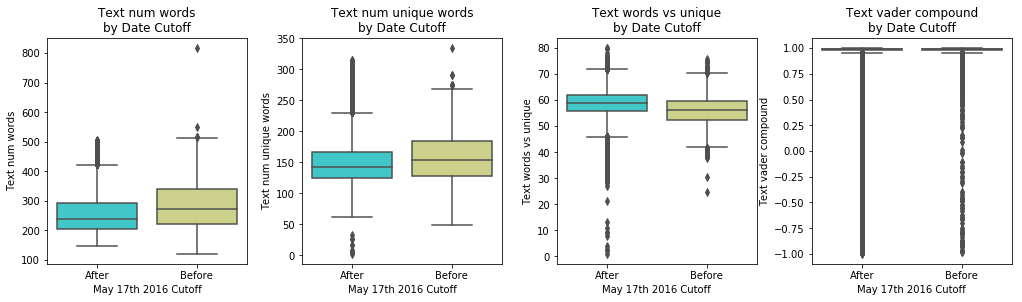

In [101]:
# Date Cutoff Variable
df["Date_Cutoff"] = None
df.loc[df["project_submitted_datetime"] > "05/16/2016","Date_Cutoff"] = "After"
df.loc[df["project_submitted_datetime"] <= "05/16/2016","Date_Cutoff"] = "Before"

# Plot
f, ax = plt.subplots(1,4, figsize=[14,4])
for i, plotcol in enumerate(["text_num_words","text_num_unique_words","text_words_vs_unique","text_vader_Compound"]):
    sns.boxplot(data=df, y=plotcol,x="Date_Cutoff",ax=ax[i], palette="rainbow")
    ax[i].set_xlabel("May 17th 2016 Cutoff")
    ax[i].set_ylabel("{}".format(plotcol.replace(r'_',' ').capitalize()))
    ax[i].set_title("{}\nby Date Cutoff".format(plotcol.replace(r'_',' ').capitalize()))
plt.tight_layout(pad=0)
plt.show()

## Time Variables

In [102]:
# Time Variables
df["Year"] = df["project_submitted_datetime"].dt.year
df["Date of Year"] = df['project_submitted_datetime'].dt.dayofyear
df["Weekday"] = df['project_submitted_datetime'].dt.weekday
df["Weekd of Year"] = df['project_submitted_datetime'].dt.week
df["Day of Month"] = df['project_submitted_datetime'].dt.day
df["Quarter"] = df['project_submitted_datetime'].dt.quarter

In [103]:
# Split the strings at the comma, and treat them as dummies
df = pd.merge(df, df["project_subject_categories"].str.get_dummies(sep=', '),
              left_index=True, right_index=True, how="left")
df = pd.merge(df, df["project_subject_subcategories"].str.get_dummies(sep=', '),
              left_index=True, right_index=True, how="left")

In [104]:
# Teacher ID
teachr_multi_subs = df['teacher_id'].value_counts().reset_index()
df["multi_apps"]= df['teacher_id'].isin(teachr_multi_subs.loc[teachr_multi_subs["teacher_id"]>1,'index'].tolist())
# Percentages
print("Teacher App Distribution:\nTwo Apps: {}%\nOne App: {}%\n".format(*df["multi_apps"].value_counts(normalize=True)*100))

Teacher App Distribution:
Two Apps: 67.55204428810335%
One App: 32.44795571189666%



## Gender Variable

In [105]:
# Teacher Gender
df["Gender"] = None
df.loc[df['teacher_prefix'] == "Mr.","Gender"] = "Male"
df.loc[df['teacher_prefix'] == "Teacher","Gender"] = "Not Specified"
df.loc[(df['teacher_prefix'] == "Mrs.")|(df['teacher_prefix'] == "Ms."),"Gender"] = "Female"

print("Gender Distribution:\nFemale: {}%\nMale: {}%\nNot Specified: {}%".format(*df["Gender"].value_counts(normalize=True)*100))

Gender Distribution:
Female: 88.06816652503758%
Male: 9.790478680657825%
Not Specified: 2.141354794304588%


In [108]:
dumyvars= ["Gender",'school_state','project_grade_category']
timevars = ['Weekday','Weekd of Year','Day of Month','Year','Date of Year',"Quarter"]
encode = ['multi_apps', "Date_Cutoff", 'teacher_prefix',"teacher_id"]

# Decided to go with only encoding, since most of the gradient boosting trees can handle categorical
categorical_features = dumyvars + timevars + encode

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical_features:
     df[col] = lbl.fit_transform(df[col].astype(str))

In [116]:
# Text
text_cols = ["project_resource_summary", "project_title","description","text"]

df.drop(['project_subject_categories',"project_subject_subcategories","project_submitted_datetime",
         "project_essay_1","project_essay_2","project_essay_3","project_essay_4"
        ],axis=1,inplace=True)
normalize = ["teacher_number_of_previously_posted_projects","quantity","price"]
gc.collect()

11843

## TF-IDF: Term Frequency-Inverse Document Frequency 

In [118]:
tfidf_para = {
    "sublinear_tf":True,
    "strip_accents":'unicode',
    "stop_words":"english",
    "analyzer":'word',
    "token_pattern":r'\w{1,}',
    "dtype":np.float32,
    "norm":'l2',
    "min_df":5,
    "max_df":.9,
    "smooth_idf":False
}

In [119]:
def get_col(col_name):
    return lambda x: x[col_name]

df["project_title_count"] = df["project_title"].copy()
textcols = ["text","project_resource_summary","project_title", "project_title_count","description"]
vectorizer = FeatureUnion([
        ('text',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=20000,
            **tfidf_para,
            preprocessor=get_col('text'))),
        ('project_resource_summary',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            max_features=2000,
            preprocessor=get_col('project_resource_summary'))),
        ('project_title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            max_features=1500,
            preprocessor=get_col('project_title'))),
        ('project_title_count',CountVectorizer(
            ngram_range=(1, 2),
            max_features=1500,
            preprocessor=get_col('project_title_count'))),
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            max_features=2400,
            preprocessor=get_col('description'))),
#         ('Non_text',DictVectorizer())
    ])

In [120]:
df.columns

Index(['teacher_id', 'teacher_prefix', 'school_state',
       'project_grade_category', 'project_title', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'quantity_sum',
       'quantity_mean', 'price_max', 'price_min', 'price_std', 'sum_price_sum',
       'count', 'description', 'price_avg', 'text', 'text_num_chars',
       'text_num_words', 'text_num_unique_words', 'text_words_vs_unique',
       'text_vader_Compound', 'text_vader_Negative', 'text_vader_Positive',
       'project_resource_summary_num_chars',
       'project_resource_summary_num_words',
       'project_resource_summary_num_unique_words',
       'project_resource_summary_words_vs_unique', 'project_title_num_chars',
       'project_title_num_words', 'project_title_num_unique_words',
       'project_title_words_vs_unique', 'description_num_chars',
       'description_num_words', 'description_num_unique_words',
       'description_words_vs_unique', 'Date_Cutoff', 'Year', 'Date of Year',
  

In [121]:
pd.set_option('display.max_columns', None) 
df.head(5)

,teacher_id,teacher_prefix,school_state,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,quantity_sum,quantity_mean,price_max,price_min,price_std,sum_price_sum,count,description,price_avg,text,text_num_chars,text_num_words,text_num_unique_words,text_words_vs_unique,text_vader_Compound,text_vader_Negative,text_vader_Positive,project_resource_summary_num_chars,project_resource_summary_num_words,project_resource_summary_num_unique_words,project_resource_summary_words_vs_unique,project_title_num_chars,project_title_num_words,project_title_num_unique_words,project_title_words_vs_unique,description_num_chars,description_num_words,description_num_unique_words,description_words_vs_unique,Date_Cutoff,Year,Date of Year,Weekday,Weekd of Year,Day of Month,Quarter,Applied Learning,Care & Hunger_x,Health & Sports,History & Civics,Literacy & Language,Math & Science,Music & The Arts,Special Needs_x,Warmth_x,Applied Sciences,Care & Hunger_y,Character Education,Civics & Government,College & Career Prep,Community Service,ESL,Early Development,Economics,Environmental Science,Extracurricular,Financial Literacy,Foreign Languages,Gym & Fitness,Health & Life Science,Health & Wellness,History & Geography,Literacy,Literature & Writing,Mathematics,Music,Nutrition Education,Other,Parent Involvement,Performing Arts,Social Sciences,Special Needs_y,Team Sports,Visual Arts,Warmth_y,multi_apps,Gender,project_title_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
p036502,37239,3,33,3,super sight word centers,my students need 6 ipod nano's to create and d...,26,6,3.0,149.99,149.99,0.000000,899.94,2,apple - ipod nano� 16gb mp3 player (8th genera...,149.99,most of my kindergarten students come from low...,1781,314,171,54.458599,0.9683,0.021,0.097,127,21,19,90.476190,24,4,4,100.0,149,28,13,46.428571,0,0,249,4,40,9,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,super sight word centers
p039565,115331,2,10,0,keep calm and dance on,my students need matching shirts to wear for d...,1,20,20.0,20.00,20.00,0.000000,400.00,1,reebok girls' fashion dance graphic t-shirt - ...,20.00,our elementary school is a culturally rich sch...,1235,192,134,69.791667,0.9052,0.022,0.095,81,12,12,100.000000,22,5,5,100.0,70,13,12,92.307692,0,1,19,2,8,18,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,keep calm and dance on
p233823,87678,3,44,0,lets 3doodle to learn,my students need the 3doodler. we are an sem s...,5,1,1.0,469.99,469.99,0.000000,469.99,1,3doodler start full edu bundle,469.99,hello;\r\nmy name is mrs. brotherton. i teach ...,1316,236,135,57.203390,0.9927,0.011,0.204,186,33,29,87.878788,21,4,4,100.0,30,5,5,100.000000,0,1,0,6,47,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,lets 3doodle to learn
p185307,42475,1,27,0,"\""kid inspired\"" equipment to increase activit...",my students need balls and other activity equi...,16,5,1.0,354.99,18.95,133.428098,684.47,5,ball pg 4'' poly set of 6 colors ball playgrou...,136.89,my students are the greatest students but are ...,2419,388,165,42.525773,0.9947,0.026,0.151,233,36,31,86.111111,72,10,10,100.0,148,27,21,77.777778,0,0,140,4,25,3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,"\""kid inspired\"" equipment to increase activit..."
p013780,85849,1,4,1,we need clean water for our culinary arts class!,my students need a water filtration system for...,42,2,2.0,355.50,355.50,0.000000,711.00,1,crown berkey water filter with 2 black and 2 p...,355.50,my students are athletes and students who are ...,1016,187,113,60.427807,0.8613,0.055,0.111,71,12,12,100.000000,48,9,9,100.0,65,12,11,91.666667,0,0,133,5,24,27,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,we need clean water for our culinary arts class!


In [62]:
pickle.dump( ready_df, open( "ready_df.p", "wb" ) ) 

In [125]:
ready_df

<260115x27400 sparse matrix of type '<class 'numpy.float64'>'
	with 49461853 stored elements in Compressed Sparse Row format>

In [39]:
start_vect=time.time()
ready_df = vectorizer.fit_transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Vectorization Runtime: 4.48 Minutes


In [43]:
df.drop(textcols,axis=1, inplace=True)
# Lets look at these variables!
print("\nDtypes of DF features:\n",df.dtypes.value_counts())
print("\nDF Shape: {} Rows, {} Columns".format(*df.shape))


Dtypes of DF features:
 int64      67
float64    13
dtype: int64

DF Shape: 260115 Rows, 80 Columns


In [129]:
df.shape

(260115, 85)

# 3. Modeling with eXtreme Gradient Boosting

In [44]:
# Get categorical var position for CatBoost
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(df,categorical_features)

In [45]:
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]])
testing = hstack([csr_matrix(df.loc[tesdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
#del df
gc.collect();

182080 Rows and 27480 Cols
78035 Rows and 27480 Cols
Feature Names Length:  27480


In [46]:
# Calculating level of imbalance for future models.
imbalance_weight = y.value_counts(normalize=True)[0]/y.value_counts(normalize=True)[1]
print("Imbalance Weight: ",imbalance_weight)

Imbalance Weight:  0.1796871962992238


In [47]:
import pickle

In [48]:
pickle.dump( X, open( "X.p", "wb" ) )

In [49]:
pickle.dump( y, open( "y.p", "wb" ) )

In [50]:
pickle.dump( testing, open( "testing.p", "wb" ) )

In [51]:
X.shape

(182080, 27480)

In [52]:
y.shape

(182080,)

In [131]:
pickle.dump( tfvocab,open( "tfvocab.p", "wb" ) )

In [132]:
# Training and Validation Set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=23)

# XGBOOST Sparse Feature Storage
d_train = xgb.DMatrix(X_train, y_train,feature_names=tfvocab)
d_valid = xgb.DMatrix(X_valid, y_valid,feature_names=tfvocab)
d_test = xgb.DMatrix(testing,feature_names=tfvocab)

In [ ]:
xgb_params = {'eta': 0.05, 
              'max_depth': 12, 
              'subsample': 0.8, 
              'colsample_bytree': 0.75,
              'scale_pos_weight': imbalance_weight,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 1.5,
              'alpha': .6
             }

In [ ]:
modelstart = time.time()
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 2000, watchlist, verbose_eval=50, early_stopping_rounds=50)
xgb_pred = model.predict(d_test)

xgb_sub = pd.DataFrame(xgb_pred,columns=["project_is_approved"],index=tesdex)
xgb_sub.to_csv("xgb_sub.csv",index=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

#del d_train, d_valid, d_test
gc.collect();

[0]	train-auc:0.772631	valid-auc:0.693685
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.906018	valid-auc:0.76629
[100]	train-auc:0.929462	valid-auc:0.775643
[150]	train-auc:0.943516	valid-auc:0.77882
[200]	train-auc:0.953672	valid-auc:0.780611
[250]	train-auc:0.961088	valid-auc:0.781917
[300]	train-auc:0.967588	valid-auc:0.782845


In [ ]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model,max_num_features=50,ax=ax)
plt.title("XGBOOST Feature Importance")
plt.show()

In [ ]:
pickle.dump( model, open( "model.p", "wb" ) )

In [ ]:
#model.save_model('xgb_model.bst')

In [ ]:
xgb_sub.head()